# Overview

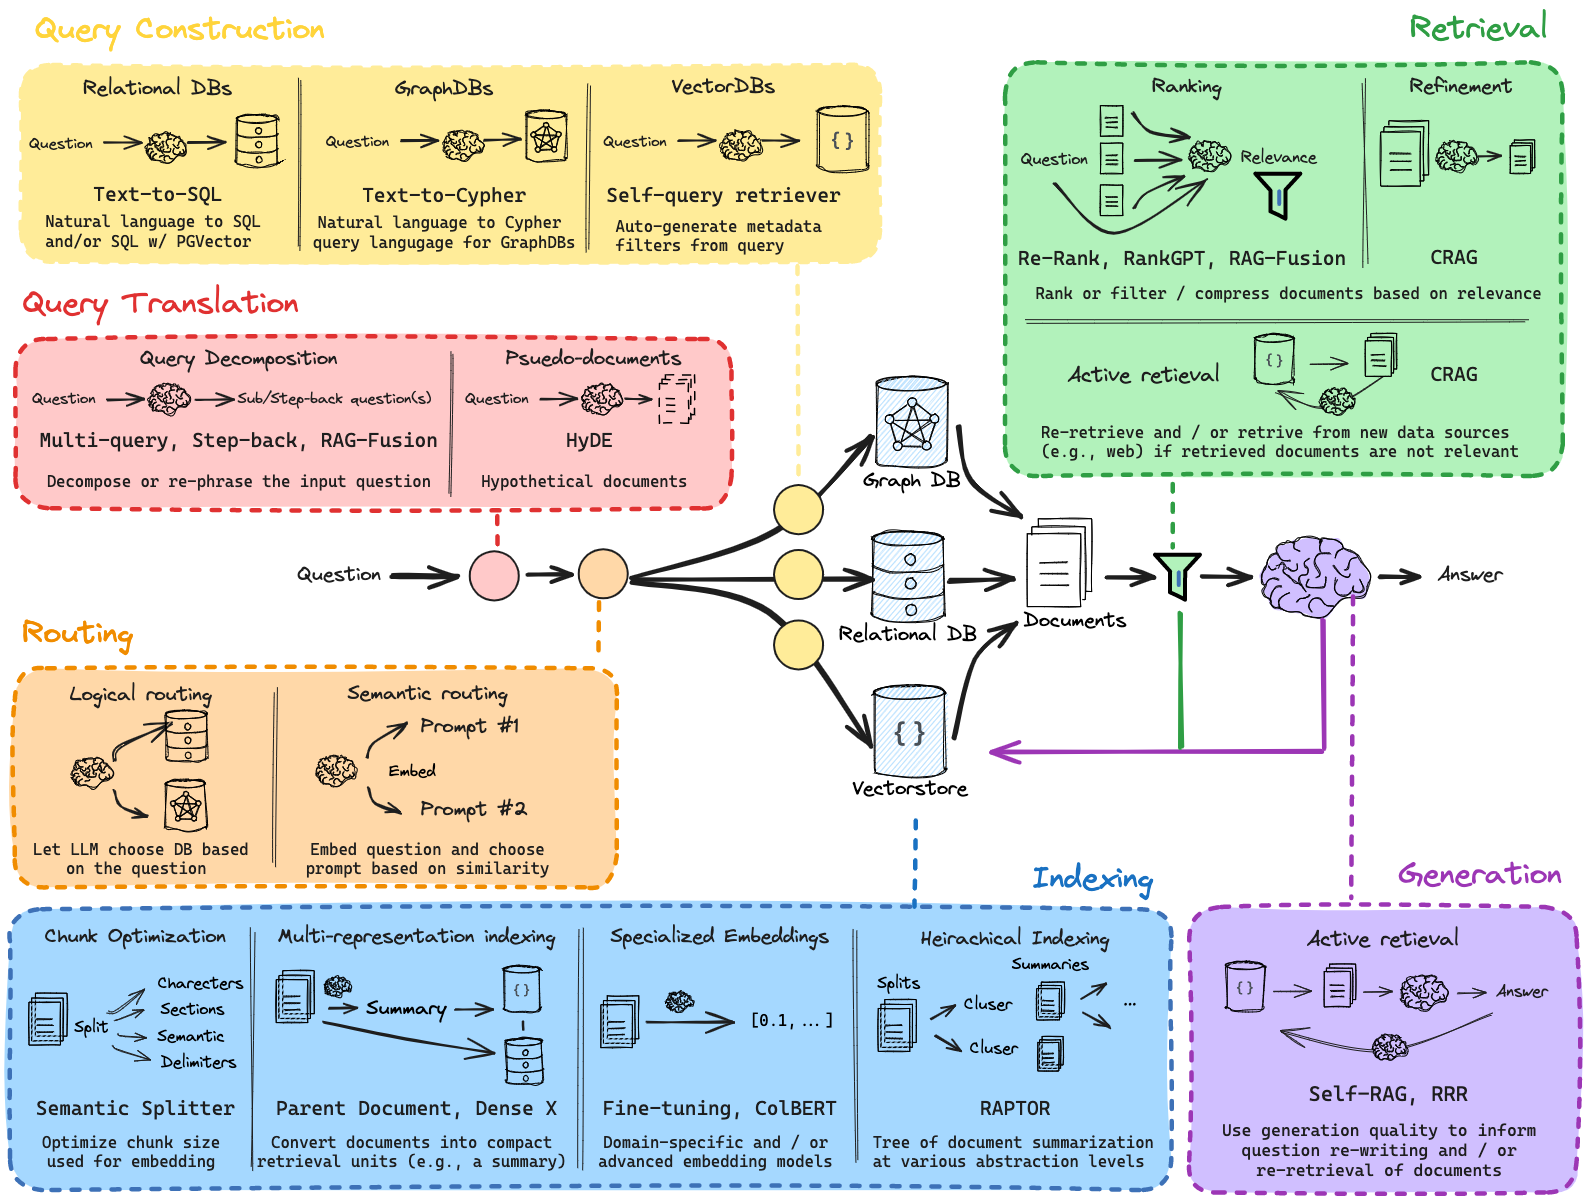

In [ ]:
# ! pip install langchain-text-splitters Beautifulsoup4

ERROR: Could not find a version that satisfies the requirement langchain-hub (from versions: none)
ERROR: No matching distribution found for langchain-hub


In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL")

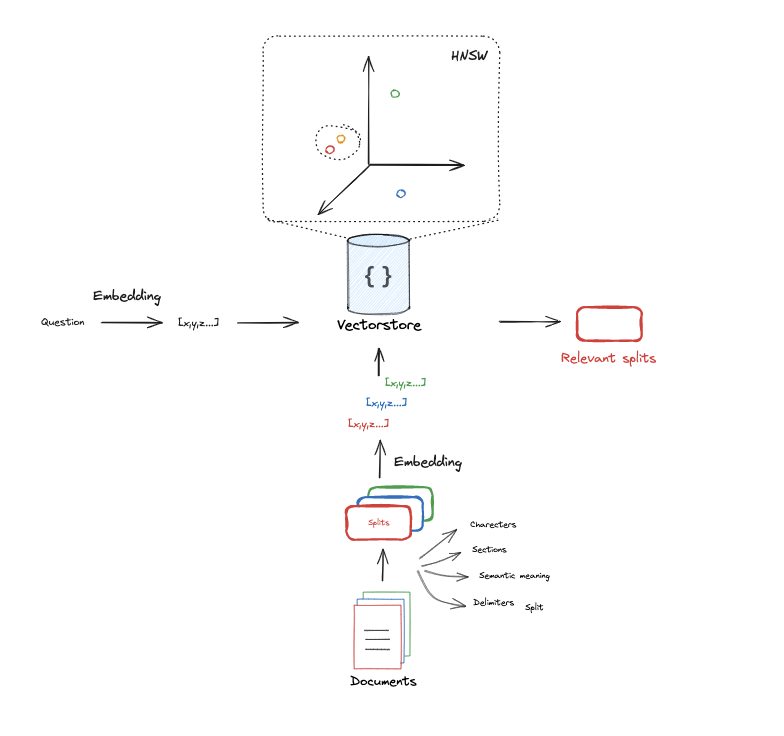

In [ ]:
# ! pip install chromadb

In [5]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate

# ==================== INDEXING ====================

# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post_title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50
)
splits = text_splitter.split_documents(blog_docs)

# Embed
embed = HuggingFaceEmbeddings(
    model_name=r"E:\users\hwy\LLMs-Technology-Projects\models\all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'}
)

vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embed
)
retriever = vectorstore.as_retriever()


# ==================== Retrieval and Generation ====================

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

# LLM
llm = ChatOpenAI(
    model="gpt-5-mini",
    temperature=0
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("What is Task Decomposition?")

'Task decomposition is breaking a complicated task into multiple smaller, simpler sub-tasks or steps so an agent can plan and solve the overall problem more easily. Techniques include Chain of Thought (prompting the model to “think step by step” to split a problem into manageable steps), Tree of Thoughts (generating multiple possible thoughts per step and exploring them in a tree with BFS/DFS and evaluation), using simple LLM prompts (e.g., “Steps for XYZ”), task-specific instructions (e.g., “Write a story outline”), or human input to produce the subgoals and ordering needed for planning.'

In [6]:
from langchain_classic import hub

prompt = hub.pull("rlm/rag-prompt")
print(prompt)

input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]

<mark>代码改进 -- 工程化</mark>

In [ ]:
# ==================== Imports ====================

import bs4
from dataclasses import dataclass
from typing import List

from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


# ==================== Config ====================

@dataclass
class RAGConfig:
    chunk_size: int = 300
    chunk_overlap: int = 50
    top_k: int = 4
    persist_dir: str = "./chroma_blog/web_demo_db"
    model_name: str = "gpt-5-mini"
    temperature: float = 0
    max_context_chars: int = 3000

config = RAGConfig()


# ==================== Indexing ====================

# Load documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs: List[Document] = loader.load()

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=config.chunk_size,
    chunk_overlap=config.chunk_overlap
)
splits = text_splitter.split_documents(docs)

# Embed & persist vector store
embed = HuggingFaceEmbeddings(
    model_name=r"E:\users\hwy\LLMs-Technology-Projects\models\all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'}
)

vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embed,
    persist_directory=config.persist_dir
)

retriever = vectorstore.as_retriever(
    search_kwargs={"k": config.top_k}
)


# ==================== Prompt ====================

prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are an assistant for question-answering tasks. "
        "Use the retrieved context to answer the question. "
        "If you don't know the answer, say you don't know."
        "Use three sentences maximum and keep the answer concise."
    ),
    (
        "human",
        "Question: {question}\n\nContext:\n{context}\n\nAnswer:"
    )
])


# ==================== LLM ====================

llm = ChatOpenAI(
    model=config.model_name,
    temperature=config.temperature
)


# ==================== Context Formatting ====================

def format_docs(docs: List[Document]) -> str:
    """Limit context length to avoid token explosion"""
    contents = []
    total_chars = 0

    for doc in docs:
        text = doc.page_content.strip()
        if total_chars + len(text) > config.max_context_chars:
            break
        contents.append(text)
        total_chars += len(text)

    return "\n\n".join(contents)


# ==================== RAG Chain ====================

rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough(),
    }
    | prompt
    | llm
    | StrOutputParser()
)


# ==================== Query ====================

question = "What is Task Decomposition?"
answer = rag_chain.invoke(question)

print(answer)

Task decomposition is breaking a complex task into smaller, manageable substeps or subgoals so an agent (or model) can plan and solve them sequentially or hierarchically. Techniques include Chain of Thought prompting (step-by-step reasoning), Tree of Thoughts (exploring multiple thought branches), simple LLM prompts asking for steps, task-specific instructions, or human-provided decompositions.
